<a href="https://colab.research.google.com/github/ngupta23/fastai_notebooks/blob/master/image_segmentation_deepdive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation | Introduction

In computer vision, image segmentation is the **<font color = red>process of partitioning a digital image into multiple segments</font>** (sets of pixels, also known as image objects). The goal of segmentation is to simplify and/or **<font color = red>change the representation of an image into something that is more meaningful and easier to analyze</font>**. 

Image segmentation is typically used to **<font color = red>locate objects and boundaries</font>** (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics. 

# Image Segmentation | Applications

**Medical imaging**

* Locate tumors and other pathologies
* Measure tissue volumes
* Diagnosis, study of anatomical structure
* Surgery planning
* Virtual surgery simulation
* Intra-surgery navigation

**Object detection**

* Pedestrian detection
* Face detection
* Brake light detection
* Locate objects in satellite images (roads, forests, crops, etc.)

Reference: https://en.wikipedia.org/wiki/Image_segmentation

# Deep Learning Concepts Covered

* Transfer Learning 
* Image Segmentation
* UNET model
* Progressive Resizing


# Libraries Used
* PyTorch
* fastai (built on top of PyTorch)

# Fast.ai | <font color = red>Making neural nets uncool again</font>

## About fast.ai

Deep learning is transforming the world. We are making deep learning easier to use and getting more people from all backgrounds involved through our:

* **[free courses for coders](https://course.fast.ai/)**
* **[software library](https://www.fast.ai/2018/10/02/fastai-ai/)**
* [cutting-edge research](https://www.theverge.com/2018/5/7/17316010/fast-ai-speed-test-stanford-dawnbench-google-intel)
* **[community](https://forums.fast.ai/)**

The world needs everyone involved with AI, no matter how unlikely your background.


## fast.ai in the news

* The Economist: [New schemes teach the masses to build AI](https://www.economist.com/business/2018/10/25/new-schemes-teach-the-masses-to-build-ai)
* MIT Tech Review: [The startup diversifying the AI workforce beyond just "techies"](https://www.technologyreview.com/s/610633/the-startup-diversifying-the-ai-workforce-beyond-just-techies/)
* The New York Times: [Finally, a Machine That Can Finish Your Sentence](https://www.nytimes.com/2018/11/18/technology/artificial-intelligence-language.html)
* The Verge: [An AI speed test shows clever coders can still beat tech giants like Google and Intel](https://www.theverge.com/2018/5/7/17316010/fast-ai-speed-test-stanford-dawnbench-google-intel)
* MIT Tech Review: [A small team of student AI coders beats Google’s machine-learning code](https://www.technologyreview.com/s/611858/small-team-of-ai-coders-beats-googles-code/)
* Forbes: [Artificial Intelligence Education Transforms The Developing World](https://www.forbes.com/sites/mariyayao/2017/04/10/why-we-need-to-democratize-ai-machine-learning-education/#411324681197)
* **ZDNet: [fast.ai's software could radically democratize AI](https://www.forbes.com/sites/mariyayao/2017/04/10/why-we-need-to-democratize-ai-machine-learning-education/#411324681197)**


## Comparison | Transfer learning in computer vision

Let’s compare the two libraries on this task (we’ve tried to match our Keras implementation as closely as possible, although since Keras doesn’t support all the features that fastai provides, it’s not identical):

|                                    | fastai resnet34* | fastai resnet50 | Keras  |
|------------------------------------|------------------|-----------------|--------|
| Lines of code (excluding imports)  | 5                | 5               | 31     |
| Stage 1 error (Tune Head Only)     | 0.70%            | 0.65%           | 2.05%  |
| Stage 2 error (Tune Full Model)    | 0.50%            | 0.50%           | 0.80%  |
| Test time augmentation (TTA) error | 0.30%            | 0.40%           | N/A*   |
| Stage 1 time                       |  4:56            | 9:30            | 8:30   |
| Stage 2 time                       | 6:44             | 12:48           |  17.38 |
	

*Keras does not provide resnet 34 or TTA

Reference: https://www.fast.ai/about/




## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

#### NOTE: 
* **Image and Labels are of the same size (image segmentation)**
* **Labels are also called `masks` in segmenation problems**

#### 2 Methods to get documentation

In [0]:
get_image_files??

In [6]:
doc(get_image_files)  

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0001TP_009750.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01080.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08109.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_007680_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_00810_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08133_P.png')]

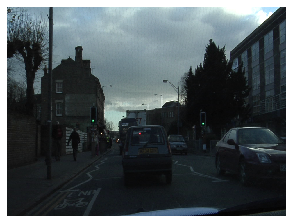

In [9]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
# What is the next cell doing (checking here) - Stem and Suffix works on paths
print(img_f)
print(img_f.stem)
print(img_f.suffix)

/root/.fastai/data/camvid/images/0001TP_009750.png
0001TP_009750
.png


In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

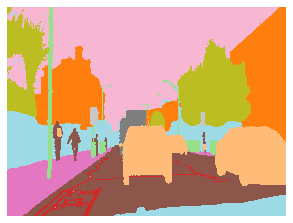

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
# What is the next line doing - check here
print(mask.shape)
src_size = np.array(mask.shape[1:]) # takes only rows and columns
print(src_size)
print(mask.data)

torch.Size([1, 720, 960])
[720 960]
tensor([[[26, 26, 26,  ...,  4,  4,  4],
         [26, 26, 26,  ...,  4,  4,  4],
         [26, 26, 26,  ...,  4,  4,  4],
         ...,
         [19, 19, 19,  ..., 30, 30, 30],
         [19, 19, 19,  ..., 30, 30, 30],
         [19, 19, 19,  ..., 30, 30, 30]]])


In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

### Create Databunch

**`Dataset`** (from PyTorch) (called **`ItemList`** in PyTorch) &rarr; **`DataLoader`** (from PyTorch) &rarr; **`Databunch`** (from fastai)

* Dataset - has __item__ and __len__ to index the data
* DataLoader - used to create mini-batches
* DataBunch - Combination of DataLoaders for Train, Validation and Test sets


### Datablock API (fastai)
**The data block API lets you customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks, mainly:**
1. Where are the inputs and how to create them?
2. How to split the data into a training and validation sets?
3. How to label the inputs?
4. What transforms to apply?
5. How to add a test set?
6. How to wrap in dataloaders and create the DataBunch?

### <font color=red> Use a source size of half. We can use transfer learning after this wih full size for faster training </font>

In [15]:
size = src_size//2  

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 11430MB of GPU RAM free


### <font color=red>**They have provided what pictures to use for the validation set. This is because the images are coming from videos so we dont want adjacent images in the video to reside in training and validation set**</font>

In [16]:
valid = np.loadtxt(path/'valid.txt', dtype=str); valid

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

### <font color=red> Split using filename file </font>

In [0]:
# doc(SegmentationItemList.split_by_fname_file)

In [18]:
path_img  

PosixPath('/root/.fastai/data/camvid/images')

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))  # classes = codes will tell it what each pixel value means

In [0]:
get_transforms??

### <font color=red> Transforming y since there is a 1:1 match between image and label. If we transform image, we need to transform the label as well.</font>

In [0]:
# This can be combined in the previous step but separated since the previous step is reused later when fine tuning with a bigger image size.
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [22]:
imagenet_stats  # Mean and SD of the RGB channels

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

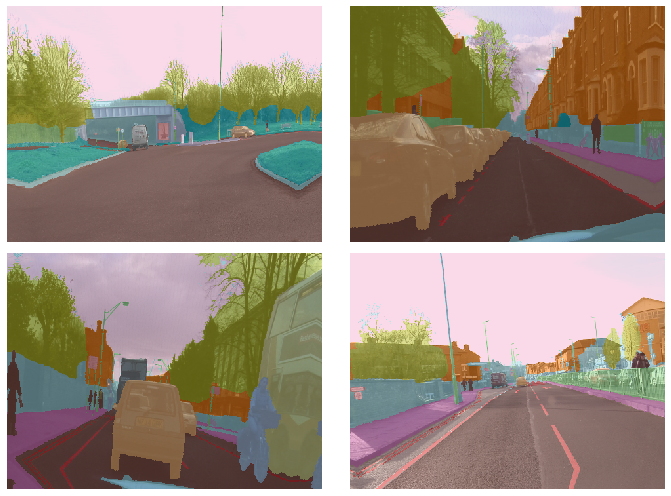

In [23]:
data.show_batch(2, figsize=(10,7))  # fastai will combine the photo with the mask and display it

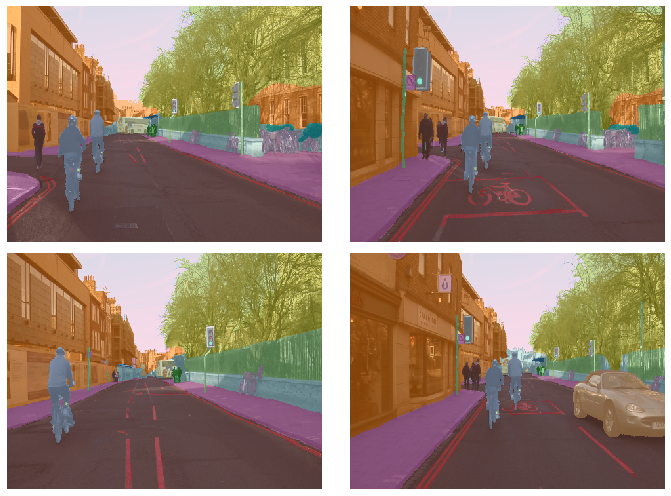

In [24]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

### <font color = red> For segmentation, U-net is better than CNN (most cited paper from the conference where it was presented!!!) </font>

* https://arxiv.org/abs/1505.04597
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [25]:
doc(unet_learner)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 159MB/s] 


### <font color = red>You can do mixed precision training (if the size of GPU ram is not sufficient) by adding `.to_fp16()` at the end of learner. This reduces the memory requirements (16 bits instead of 32 bits), but needs the latest CUDA drivers, etc. since it is so new.</font>

`learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()`

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


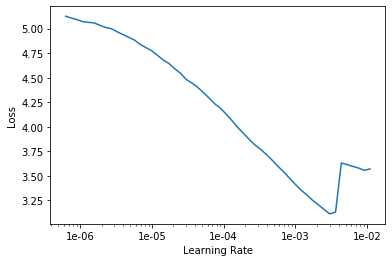

In [30]:
lr_find(learn)
learn.recorder.plot()

In [0]:
# lr=3e-3 from original notebook
# lr = 1e-4 # my original trail
lr = 1e-3

In [32]:
doc(learn.fit_one_cycle)

In [33]:
# learn.fit_one_cycle(10, slice(lr), pct_start=0.9)  # from originl notebook
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.043273,0.748485,0.827183,03:40
1,0.785307,0.780607,0.787907,03:29
2,0.686302,0.642957,0.843700,03:28
3,0.598119,0.475431,0.867665,03:27
4,0.536702,0.406522,0.890661,03:27
5,0.477897,0.393419,0.876263,03:26
6,0.398425,0.338858,0.898992,03:26
7,0.359625,0.292496,0.917998,03:26
8,0.336213,0.281111,0.921195,03:26
9,0.307129,0.274114,0.922574,03:27


### <font color = red> You want the loss to go up initially and then go down. This means that you have picked the best possible max learning rate. (The loss goes up initially since lr is too high so that means that you have not left anything on the table in terms of training speed.). Ofcourse this is only valid if the loss comes down eventually.</font>

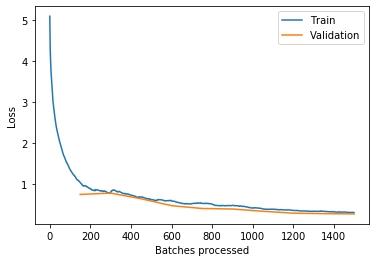

In [34]:
learn.recorder.plot_losses()

### <font color = red> Learning Rate goes up initially so that we make fast progress, cross the local minima and saddle points quickly and then the learning rate is reduced as we come closer to the global minima. The idea of reducing learning rate has been around for a while and is called learning rate annealing. But the idea of increasing the learning rate initially is fairly new (thanks to Leslie Smith).</font>

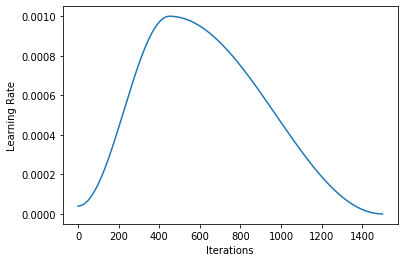

In [35]:
learn.recorder.plot_lr()  

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

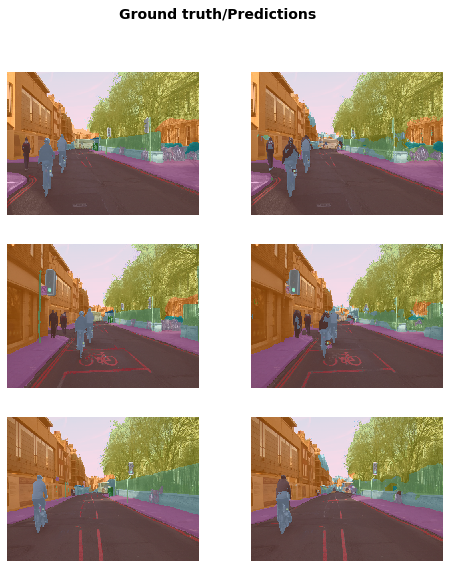

In [38]:
learn.show_results(rows=3, figsize=(8,9))

### <font color = red> I will stop here since it takes a lot of time to train these models + my memory usage is at its limit (see below). But we could essentialy go on to fine tune this model, then apply transfer learning to the full size image (with reduced batch size) </font>

![](https://github.com/ngupta23/fastai_notebooks/blob/master/images/camvid/memory_usage_stage1_small.jpg?raw=1)

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


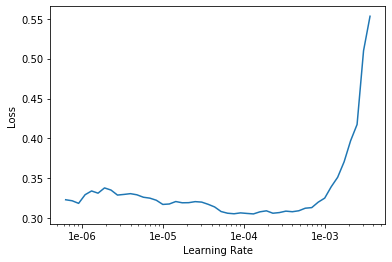

In [40]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(lr/400,lr/4)

In [42]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.304298,0.275770,0.921003,03:36
1,0.303024,0.276104,0.921288,03:36
2,0.312137,0.281792,0.920514,03:37
3,0.304821,0.272032,0.923397,03:37
4,0.300061,0.280836,0.919591,03:37
5,0.302875,0.256497,0.930362,03:37
6,0.282276,0.295660,0.919768,03:38
7,0.272872,0.258346,0.927547,03:39
8,0.286281,0.285156,0.915111,03:39
9,0.268449,0.303730,0.911609,03:39


In [0]:
learn.save('stage-2');

## Go big (Progressive Resizing)

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [44]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=2, have 11113MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


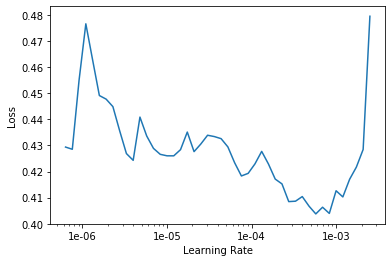

In [48]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.337698,0.300599,0.915640,13:58
1,0.333185,0.305256,0.915220,13:46
2,0.348674,0.308512,0.916454,13:46
3,0.380105,0.341039,0.904425,13:42


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

In [0]:
learn.show_results(rows=3, figsize=(10,10))

## fin

# Other Formats

* [Run Length Encoding](https://en.wikipedia.org/wiki/Run-length_encoding)
* [fastai for RLE](https://docs.fast.ai/vision.image.html#Run-length-encoded-masks)